In [1]:
import numpy as np
import math
from math import pi as pi
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import figure
%matplotlib notebook

In [2]:
from scipy.io import netcdf_file

# https://resources.marine.copernicus.eu/product-download/SEALEVEL_EUR_PHY_L4_MY_008_068
f = netcdf_file("data2.nc")
###f = netcdf_file("04032020.nc")
##f = netcdf_file("04032019.nc")
f.variables

OrderedDict([('ugos', <scipy.io.netcdf.netcdf_variable at 0x7fbd002b4490>),
             ('vgos', <scipy.io.netcdf.netcdf_variable at 0x7fbd01d2ceb0>),
             ('vgosa', <scipy.io.netcdf.netcdf_variable at 0x7fbd01d2cee0>),
             ('crs', <scipy.io.netcdf.netcdf_variable at 0x7fbd01d3be80>),
             ('err_vgosa',
              <scipy.io.netcdf.netcdf_variable at 0x7fbd01d3bf10>),
             ('latitude', <scipy.io.netcdf.netcdf_variable at 0x7fbd01d3bfd0>),
             ('nv', <scipy.io.netcdf.netcdf_variable at 0x7fbd01d4a0a0>),
             ('sla', <scipy.io.netcdf.netcdf_variable at 0x7fbd01d4a130>),
             ('ugosa', <scipy.io.netcdf.netcdf_variable at 0x7fbd01d4a250>),
             ('lat_bnds', <scipy.io.netcdf.netcdf_variable at 0x7fbd01d4a2b0>),
             ('flag_ice', <scipy.io.netcdf.netcdf_variable at 0x7fbd01d4a340>),
             ('adt', <scipy.io.netcdf.netcdf_variable at 0x7fbd01d4a400>),
             ('err_ugosa',
              <scipy.io.netcdf.ne

In [3]:
lat = f.variables['latitude'].data
long = f.variables['longitude'].data

In [4]:
vel_x = f.variables['ugos'].data.squeeze()
print(vel_x.shape[0])
vel_y = f.variables['vgos'].data.squeeze()
print(vel_y.shape)

321
(321, 81)


In [5]:
print(f"Missing values in x: {np.isnan(np.amin(vel_x))}, at {np.argwhere(np.isnan(vel_x))}")
print(f"Missing values in y: {np.isnan(np.amin(vel_y))}, at {np.argwhere(np.isnan(vel_y))}")

Missing values in x: True, at [[150  23]]
Missing values in y: True, at [[150  23]]


In [6]:
from common_functions import interpolate_missing_point

imputed_vel_x = interpolate_missing_point(vel_x, np.ma.masked_invalid(vel_x).mask)
imputed_vel_y = interpolate_missing_point(vel_y, np.ma.masked_invalid(vel_y).mask)

<IPython.core.display.Javascript object>


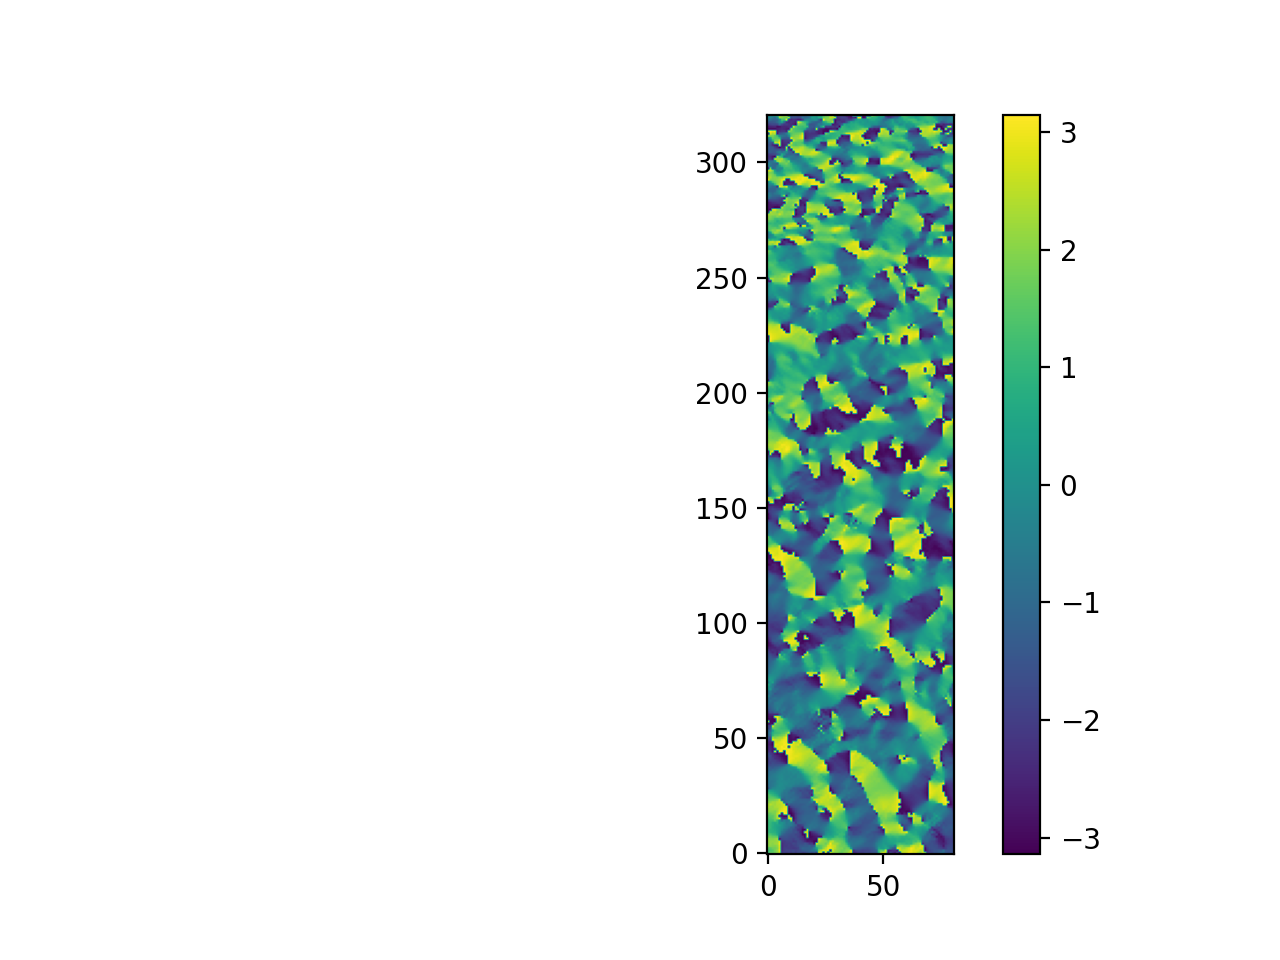

In [7]:
theta = np.arctan2(imputed_vel_y, imputed_vel_x)
plt.figure()
plt.imshow(theta, origin = 'lower')
plt.colorbar()

In [8]:
print("Size of grid in y direction is,", theta.shape[0])
print("Size of grind in x direction is,", theta.shape[1])

Size of grid in y direction is, 321
Size of grind in x direction is, 81


In [9]:
def calc_grid_direction(theta,xCoord,yCoord):
    #theta is angle in radians of the direction of the vector. Measured anticlockwise from the horizontal
    #i,j are the x,y indeces of the cell of the vector
    #returns output of the cell the vector is pointing to

    #Initialise output indices as same as current cell
    xCoord_out = xCoord
    yCoord_out = yCoord
    

    #Determine which region angle falls in
    if -np.pi/8 < theta <= np.pi/T8:
        cell = 1
        xCoord_out += 1
    elif np.pi/8 < theta <= 3*np.pi/8:
        cell = 2
        xCoord_out += 1
        yCoord_out += 1
    elif 3*np.pi/8 < theta <= 5*np.pi/8:
        cell = 3
        yCoord_out += 1
    elif 5*np.pi/8 < theta <= 7*np.pi/8:
        cell = 4
        xCoord_out -= 1
        yCoord_out += 1
    elif 7*np.pi/8 < theta <= np.pi or -np.pi <= theta <= -7*np.pi/8:
        cell = 5
        xCoord_out -= 1
    elif -7*np.pi/8 < theta <= -5*np.pi/8:
        cell = 6
        xCoord_out -= 1
        yCoord_out -= 1
    elif -5*np.pi/8 < theta <= -3*np.pi/8:
        cell = 7
        yCoord_out -= 1
    elif -3*np.pi/8 < theta <= -np.pi/8:
        cell = 8
        xCoord_out += 1
        yCoord_out -= 1
    else:
        #print("Error: not in within any sectors")
        cell = np.nan

        
    return cell, xCoord_out, yCoord_out

In [10]:
def streamline_calculator(initial_xCoord, initial_yCoord):
    
    from collections import Counter

    #Initialise variables and lists
    visited_points = []
    n=0 #While loop counter
    i=initial_xCoord #Starting x-coordinate
    j=initial_yCoord #Starting y-coordinate
    visited_points.append([j, i]) #Initial starting coordinates

    phi = 0 #Winding angle
    winding_angle = [] #List to see how angle evolves over time
    

    while n < 1000:
        cell, xCoord, yCoord = calc_grid_direction(theta[j][i], i, j)
        
        #Check if coordinates are in bounds
        if yCoord < 0 or xCoord < 0 or yCoord > theta.shape[0]-1 or xCoord > theta.shape[1]-1 or np.isnan(imputed_vel_x[xCoord]).any() or np.isnan(imputed_vel_y[yCoord]).any():
            break
            
        alpha_1 = theta[j][i]
        alpha_2 = theta[yCoord][xCoord]
        i = xCoord
        j = yCoord
        phi += alpha_1 - alpha_2
        winding_angle.append(phi)
    
        frequency = visited_points.count([yCoord, xCoord]) #Checks if 

        if abs(phi%(2*pi)) < 0.2:
            #print("A full wind")
            if frequency > 0:
                #print("Possible eddy")
                #print("Coordinates of loop:", xCoord, yCoord)

                index = visited_points.index([yCoord, xCoord])
                #print("Index of start point in list:", index)
                #print("The number of iterations to find eddy:", n)

                xCoord_total = 0
                yCoord_total = 0
                #test_list = []


                for m in range(index, n+1):
                    xCoord_total += visited_points[m][1]
                    yCoord_total += visited_points[m][0]
                    #test_list.append([visited_points[m][0], visited_points[m][1]])

                eddy_centre = [round(yCoord_total/(n+1-index)), round(xCoord_total/(n+1-index))]
                #print("The eddy is centred at:", eddy_centre)

                #print(test_list)

                return eddy_centre
                
                break
            
        visited_points.append([yCoord, xCoord])
        n += 1

    

In [11]:
eddy_centres = []
spacing = 10

for i in range(0, round(theta.shape[0]/spacing)): #y coords
    i = i*spacing
    for j in range(0, round(theta.shape[1]/spacing)): #x coords
        j = j*spacing
        eddy_centres.append(streamline_calculator(j, i))

        
eddy_centres = list(filter(lambda item: item is not None, eddy_centres)) #removes None values from list

unique_centres = []
for i in eddy_centres: 
    if i not in unique_centres: 
        unique_centres.append(i) 

print(unique_centres)

[[37, 10], [29, 56], [38, 10], [76, 38], [144, 55], [118, 42], [120, 19], [119, 42], [136, 54], [158, 31], [139, 23], [180, 74], [179, 11], [184, 31], [192, 65], [202, 30], [318, 38], [295, 14], [266, 39], [276, 52], [270, 70], [314, 50]]


<IPython.core.display.Javascript object>


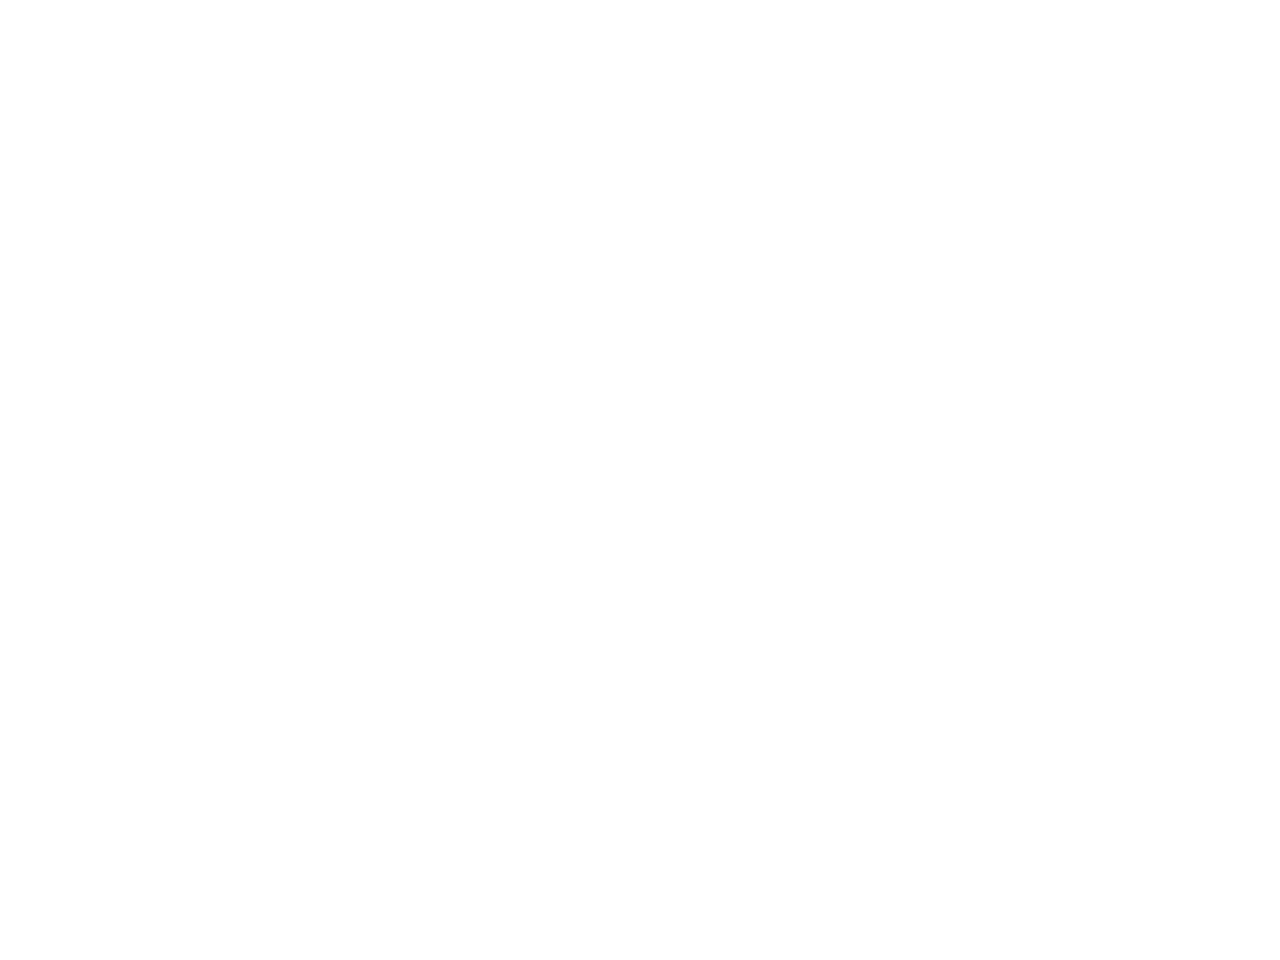

<IPython.core.display.Javascript object>


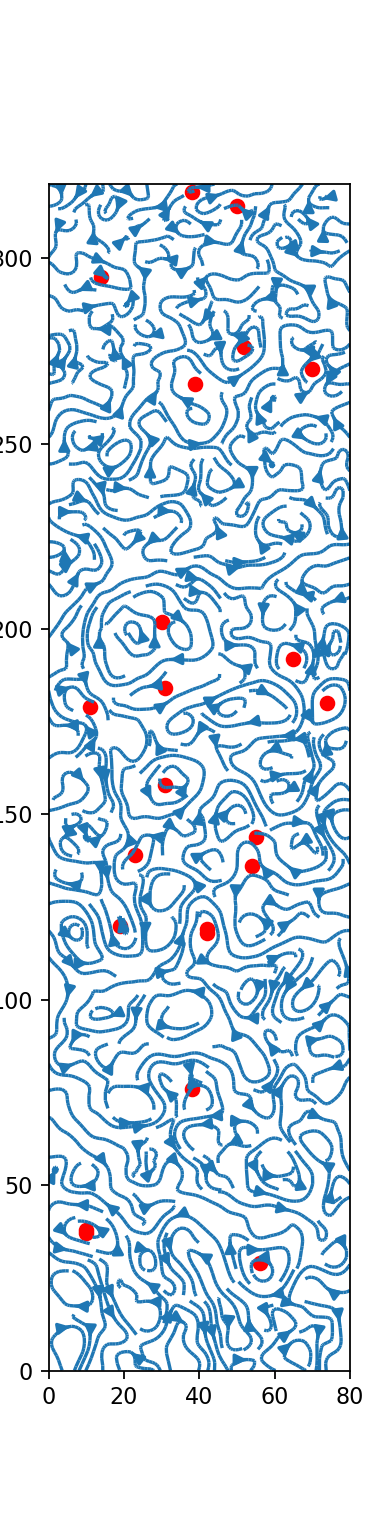

In [12]:
y = np.arange(0, theta.shape[0])
x = np.arange(0, theta.shape[1])

X, Y = np.meshgrid(x, y)

fig = plt.figure()
figure(figsize=(2.43, 9.63), dpi = 80)
plt.streamplot(X, Y, imputed_vel_x, imputed_vel_y, density = 3)
plt.show()

In [13]:
xCoords = []
yCoords = []
for i in unique_centres:
    xCoords.append(i[1])
    yCoords.append(i[0])

plt.scatter(xCoords, yCoords, color='r')
plt.show()